In [2]:
from math import sqrt
from sklearn.model_selection import train_test_split
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from pandas import to_datetime
from pandas import to_numeric
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import tensorflow as tf 
from keras.layers import LSTM, GRU, Bidirectional, Dropout, Concatenate,  SimpleRNN, Conv1D,GlobalMaxPooling1D,TimeDistributed, MaxPooling1D, Flatten


In [3]:
# convert series to supervised learning
def series_to_supevised(dataset, n_in=1, n_out=1, dropnan=True):
    num_vars = 1 if type(dataset) is list else dataset.shape[1]
    dataframe = DataFrame(dataset)
    cols, names = list(), list()
    
    # input sequence (t-n, ....t-1)
    for i in range(n_in, 0, -1):
        cols.append(dataframe.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(num_vars)]
    # forecast sequence (t, t+1 .... t+n)
    for i in range(0, n_out):
        cols.append(dataframe.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(num_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(num_vars)]
    
    # put it all together 
    agg = concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [4]:
dataset = read_csv("C:/Users/anjal/OneDrive/Desktop/BDA_Project/KAG_energydata_complete.csv")
values = dataset.values
#values = values[:100,:]

In [5]:
import pandas as pd
values[:,0] = to_numeric(to_datetime(values[:,0]))
print (values)
#values[0,:] = pd.to_numeric(pd.to_datetime(values[0,:]))

[[1452531600000000000 60 30 ... 5.3 13.275433157104999 13.275433157104999]
 [1452532200000000000 60 30 ... 5.2 18.606194981839508 18.606194981839508]
 [1452532800000000000 50 30 ... 5.1 28.64266816759482 28.64266816759482]
 ...
 [1464370800000000000 270 10 ... 13.2666666666667 29.19911708449945
  29.19911708449945]
 [1464371400000000000 420 10 ... 13.2333333333333 6.322783650830388
  6.322783650830388]
 [1464372000000000000 430 10 ... 13.2 34.11885058740154 34.11885058740154]]


In [6]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [7]:
# frame as supervised learning
reframed = series_to_supevised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[29,30,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57]], axis=1, inplace=True)
print("reframed: ", reframed.shape, "reframed head: ", reframed.head())

# split into train and test sets
values = reframed.values

X = values[:,:29]
Y = values[:,29]
#Y2 = dataset[:,16]  


# Split Data to Train and Test
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.3)

# reshape input to be 3D [samples, timesteps, features]
X_Train = X_Train.reshape((X_Train.shape[0], 1, X_Train.shape[1]))
X_Test = X_Test.reshape((X_Test.shape[0], 1, X_Test.shape[1]))
print(X_Train.shape[1])
print(X_Train.shape[2])

reframed:  (19734, 30) reframed head:     var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.000000   0.046729   0.428571    0.32735   0.566187   0.225345   
2   0.000051   0.046729   0.428571    0.32735   0.541326   0.225345   
3   0.000101   0.037383   0.428571    0.32735   0.530502   0.225345   
4   0.000152   0.037383   0.571429    0.32735   0.524080   0.225345   
5   0.000203   0.046729   0.571429    0.32735   0.531419   0.225345   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var21(t-1)  var22(t-1)  \
1   0.684038   0.215188   0.746066    0.351351  ...    0.677290    0.372990   
2   0.682140   0.215188   0.748871    0.351351  ...    0.678532    0.369239   
3   0.679445   0.215188   0.755569    0.344745  ...    0.676049    0.365488   
4   0.678414   0.215188   0.758685    0.341441  ...    0.671909    0.361736   
5   0.676727   0.215188   0.758685    0.341441  ...    0.671909    0.357985   

   var23(t-1)  var24(t-1)  var25(t-1)  var26(t-1)  var27(t-

In [8]:
model = Sequential()
model.add((LSTM(40,return_sequences=True, input_shape=(X_Train.shape[1], X_Train.shape[2]))))
model.add(Dropout(0.2))
model.add((LSTM(20,return_sequences=True)))
model.add(Dropout(0.3))
model.add((LSTM(20,return_sequences=False)))
model.add(Dropout(0.2))

model.add(Dense(1,activation='relu'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy', 'mse','mae','mape','msle'])

# fit
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(X_Train, Y_Train, epochs=70, batch_size=128,callbacks=[callback], validation_data=(X_Test, Y_Test), verbose=2, shuffle=True)


C:\Users\anjal\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/70
108/108 - 12s - 112ms/step - accuracy: 0.7756 - loss: 0.0125 - mae: 0.0791 - mape: 37586264.0000 - mse: 0.0125 - msle: 0.0092 - val_accuracy: 0.7666 - val_loss: 0.0115 - val_mae: 0.0704 - val_mape: 28674626.0000 - val_mse: 0.0115 - val_msle: 0.0083
Epoch 2/70
108/108 - 1s - 7ms/step - accuracy: 0.7756 - loss: 0.0074 - mae: 0.0524 - mape: 22635006.0000 - mse: 0.0074 - msle: 0.0054 - val_accuracy: 0.7666 - val_loss: 0.0053 - val_mae: 0.0364 - val_mape: 10126269.0000 - val_mse: 0.0053 - val_msle: 0.0038
Epoch 3/70
108/108 - 1s - 7ms/step - accuracy: 0.7755 - loss: 0.0056 - mae: 0.0395 - mape: 13384749.0000 - mse: 0.0056 - msle: 0.0041 - val_accuracy: 0.7666 - val_loss: 0.0052 - val_mae: 0.0341 - val_mape: 7633109.5000 - val_mse: 0.0052 - val_msle: 0.0037
Epoch 4/70
108/108 - 1s - 7ms/step - accuracy: 0.7756 - loss: 0.0053 - mae: 0.0377 - mape: 12635824.0000 - mse: 0.0053 - msle: 0.0039 - val_accuracy: 0.7666 - val_loss: 0.0051 - val_mae: 0.0338 - val_mape: 8157928.0000 - val_ms

In [9]:
print(model.metrics_names)
model.evaluate(X_Test,Y_Test)

['loss', 'compile_metrics']
186/186 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7669 - loss: 0.0047 - mae: 0.0305 - mape: 6067190.5000 - mse: 0.0047 - msle: 0.0035


[0.004967973567545414,
 0.7665934562683105,
 0.004967973567545414,
 0.03084886446595192,
 6376817.5,
 0.00363269099034369]

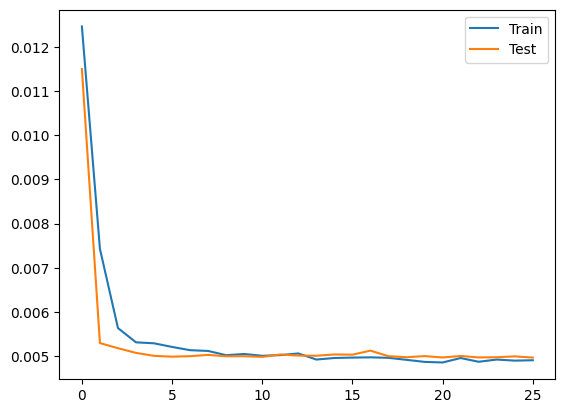

In [11]:
# plot history
pyplot.plot(history.history['loss'], label='Train')
pyplot.plot(history.history['val_loss'], label='Test')
pyplot.legend()
pyplot.show()

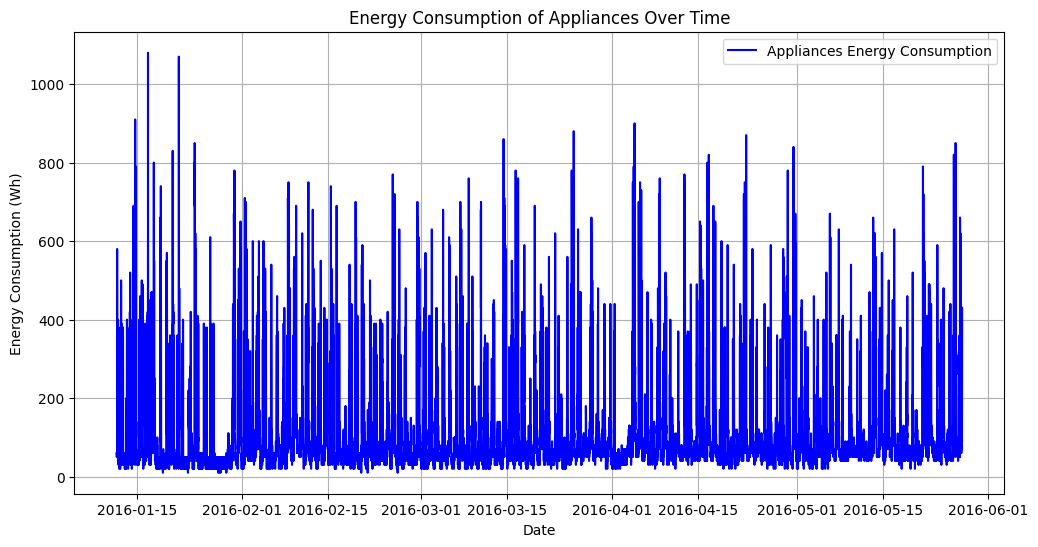

In [37]:
# Convert 'date' column to datetime
dataset['date'] = pd.to_datetime(dataset['date'])

# Plot Energy Consumption Over Time
pyplot.figure(figsize=(12, 6))
pyplot.plot(dataset['date'], dataset['Appliances'], label='Appliances Energy Consumption', color='blue')
pyplot.title('Energy Consumption of Appliances Over Time')
pyplot.xlabel('Date')
pyplot.ylabel('Energy Consumption (Wh)')
pyplot.legend()
pyplot.grid()
pyplot.show()



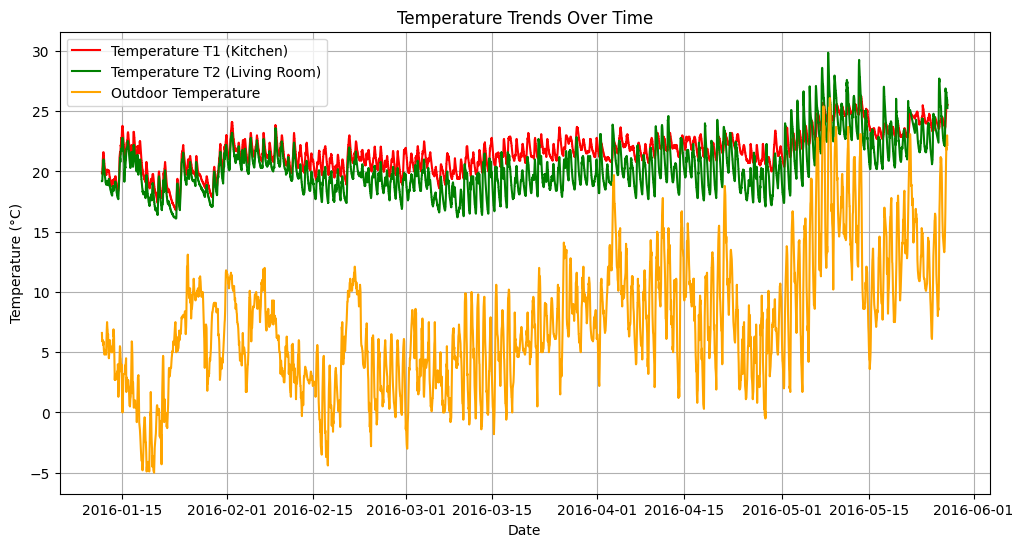

In [33]:
# Plot Temperature Trends
pyplot.figure(figsize=(12, 6))
pyplot.plot(dataset['date'], dataset['T1'], label='Temperature T1 (Kitchen)', color='red')
pyplot.plot(dataset['date'], dataset['T2'], label='Temperature T2 (Living Room)', color='green')
pyplot.plot(dataset['date'], dataset['T_out'], label='Outdoor Temperature', color='orange')
pyplot.title('Temperature Trends Over Time')
pyplot.xlabel('Date')
pyplot.ylabel('Temperature (°C)')
pyplot.legend()
pyplot.grid()
pyplot.show()

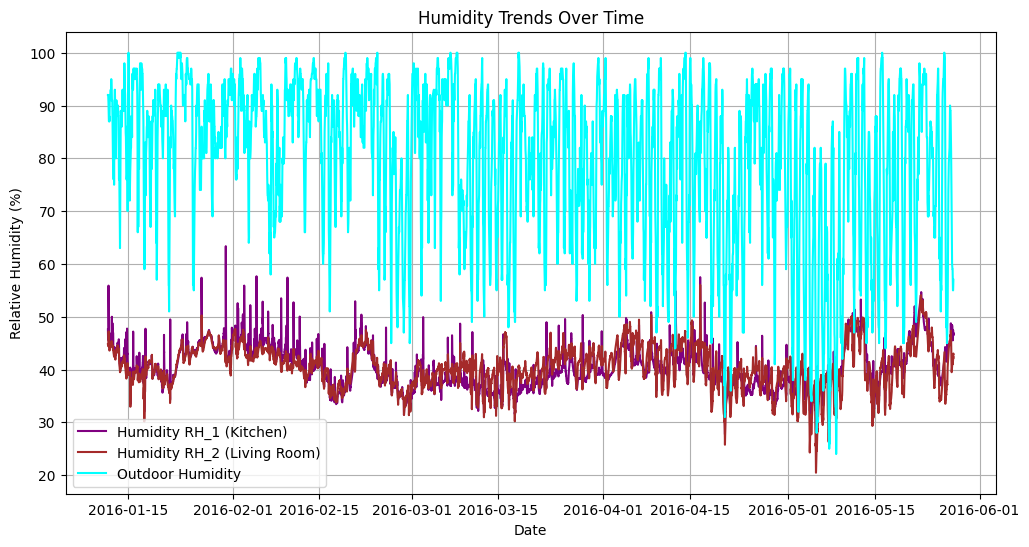

In [35]:

# Plot Humidity Trends
pyplot.figure(figsize=(12, 6))
pyplot.plot(dataset['date'], dataset['RH_1'], label='Humidity RH_1 (Kitchen)', color='purple')
pyplot.plot(dataset['date'], dataset['RH_2'], label='Humidity RH_2 (Living Room)', color='brown')
pyplot.plot(dataset['date'], dataset['RH_out'], label='Outdoor Humidity', color='cyan')
pyplot.title('Humidity Trends Over Time')
pyplot.xlabel('Date')
pyplot.ylabel('Relative Humidity (%)')
pyplot.legend()
pyplot.grid()
pyplot.show()